In [1]:
# Dataset Name: Nursery Dataset
# Dataset Location: https://archive.ics.uci.edu/ml/datasets/Nursery
# Paper Read: 
# Date Started: 11/7/2020
# Algorithm: Bayesian Networks

# Goal: Find the structure of the network with variables given

# Attribute Information:
# parents: usual, pretentious, great_pret
# has_nurs: proper, less_proper, improper, critical, very_crit
# form: complete, completed, incomplete, foster
# children: 1, 2, 3, more
# housing: convenient, less_conv, critical
# finance: convenient, inconv
# social: non-prob, slightly_prob, problematic
# health: recommended, priority, not_recom


In [2]:
# Imports for Probablistic graphical models and Bayesian Networks
import networkx as nx
import pylab
!pip install pgmpy
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator, ParameterEstimator, PC, HillClimbSearch, ExhaustiveSearch, TreeSearch
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

# How the progress bar is done
from tqdm import trange

# Standard Machine Learning Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle



     |████████████████████████████████| 327kB 5.3MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Import local files into google colab
from google.colab import files
uploaded = files.upload()

Saving EMPLOY.txt to EMPLOY.txt
Saving nursery.data to nursery.data
Saving nursery.names to nursery.names
Saving SOCIAL_HEALTH.txt to SOCIAL_HEALTH.txt
Saving STRUCTURE.txt to STRUCTURE.txt
Saving STRUCTURE_FINANCE.txt to STRUCTURE_FINANCE.txt


In [4]:
# Upload the data
leaf_nodes = ['parents', 'has_nurs','form', 'children', 'housing', 'finance', 'social', 'health', 'target']
df = pd.read_csv('nursery.data', names=leaf_nodes)
# Head of the Dataframe
print(df.columns)

Index(['parents', 'has_nurs', 'form', 'children', 'housing', 'finance',
       'social', 'health', 'target'],
      dtype='object')


In [5]:
# Load in values of nodes not in dataset
def new_aggregate(data, txt, leaf_names, new_col_name):
  agg_map = {}
  for line in open(txt).readlines():
    line_list = line.split()
    # keys = (line_list[0], line_list[1])
    keys = tuple([i for i in line_list[:-1]])
    val = line_list[-1]
    agg_map[keys] = val
  data[new_col_name] = np.nan
  new_col = []
  for row in data.iterrows():
    row_series = row[1]
    row_key = tuple([row_series[name] for name in leaf_names])
    new_col_value = agg_map[row_key]
    new_col.append(new_col_value)

  data[new_col_name] = new_col 
  return data
employ_names = ['parents', 'has_nurs']
df = new_aggregate(df,'EMPLOY.txt', employ_names, 'EMPLOY')
structure_names = ['form','children']
df = new_aggregate(df,'STRUCTURE.txt', structure_names,'STRUCTURE')
soc_health_names =  ['social','health']
df = new_aggregate(df,'SOCIAL_HEALTH.txt', soc_health_names, 'SOC_HEALTH')
structure_finan_names =  ['STRUCTURE','housing','finance']
df = new_aggregate(df,'STRUCTURE_FINANCE.txt', structure_finan_names, 'STRUCTURE_FINAN')

In [6]:
# Number of Unique Values for Each of a attributes 
df.nunique()

parents            3
has_nurs           5
form               4
children           4
housing            3
finance            2
social             3
health             3
target             5
EMPLOY             4
STRUCTURE          3
SOC_HEALTH         3
STRUCTURE_FINAN    3
dtype: int64

In [7]:
# Length of the dataframe
N = len(df)
print("Number of rows: ", N)

Number of rows:  12960


In [8]:
# EDA
# Look at the Target class balance/imbalance 
df.target.value_counts()/N

not_recom     0.333333
priority      0.329167
spec_prior    0.312037
very_recom    0.025309
recommend     0.000154
Name: target, dtype: float64

In [9]:
# Split the Data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
targets = df['target']
features = df.drop(['target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.33)
train_data = pd.concat([X_train,y_train], axis=1)
train_data = shuffle(train_data)
test_data = pd.concat([X_test, y_test], axis=1)
test_data = shuffle(test_data)

In [11]:
# Learn the Structure of the data 
from itertools import permutations
est = HillClimbSearch(data=train_data, use_cache=False)
# The model does not use leaf nodes 
blacklisted_edges = set(permutations(leaf_nodes, 2))
# k2score was bad for this model 
estimated_model = est.estimate(scoring_method="bdeuscore",black_list=blacklisted_edges)

  0%|          | 13/1000000 [00:03<70:40:22,  3.93it/s]


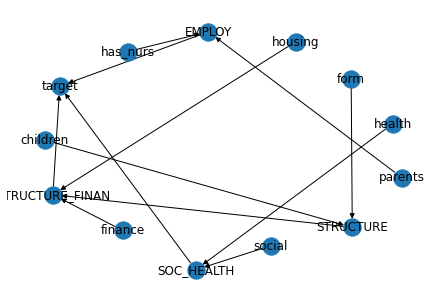

In [12]:
# Draw the Model
nx.draw(estimated_model, with_labels=True)
pylab.show()

In [ ]:
# Make the Model a Pgmpy BayesianModel object
model = BayesianModel(estimated_model.edges())
model.fit(data=train_data)
# Predict with the Bayes Model
data_preds = test_data.drop(['target'], axis=1)
preds = model.predict(data_preds)

 83%|████████▎ | 3560/4277 [02:28<00:30, 23.28it/s]

In [ ]:
# Test Accuracy of the network
LEN_TEST = len(test_data)
test_target_vector = test_data['target'].values
prediction_vector = preds.values.reshape(-1)
accuracy = sum(test_data['target'].values == prediction_vector)/len(test_data)
print("Accuracy of the Bayesian Model: ", accuracy)

Accuracy of the Bayesian Model:  1.0


In [ ]:
# Results Post:

# This model was already found out by a few scientists. We get perfect accuracy from a known model